In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import warnings
import soundfile as sf
import pandas as pd
import pyloudnorm as pyln
warnings.simplefilter("ignore")

In [3]:
filename = 'Tracks for Milan/Good/Bender - Karma.wav'
y, sr = librosa.load(filename, duration = 10.2)

### length

In [4]:
def get_length(y, sr):
    return {'length' : len(y)/sr}

get_length(y, sr)

{'length': 10.2}

### loudness

In [5]:
def get_loudness(filename):
    data, rate = sf.read(filename)
    meter = pyln.Meter(rate) #
    loudness = meter.integrated_loudness(data)  
    return {'loudness' : loudness}

get_loudness(filename)

{'loudness': -7.567026825050204}

### tempo

In [7]:
def get_temp(y, sr):
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    return {'tempo' : tempo}

get_temp(y, sr)

{'tempo': 112.34714673913044}

### pitch tuning

##### Given a collection of pitches, estimate its tuning offset (in fractions of a bin) relative to A440=440.0Hz.
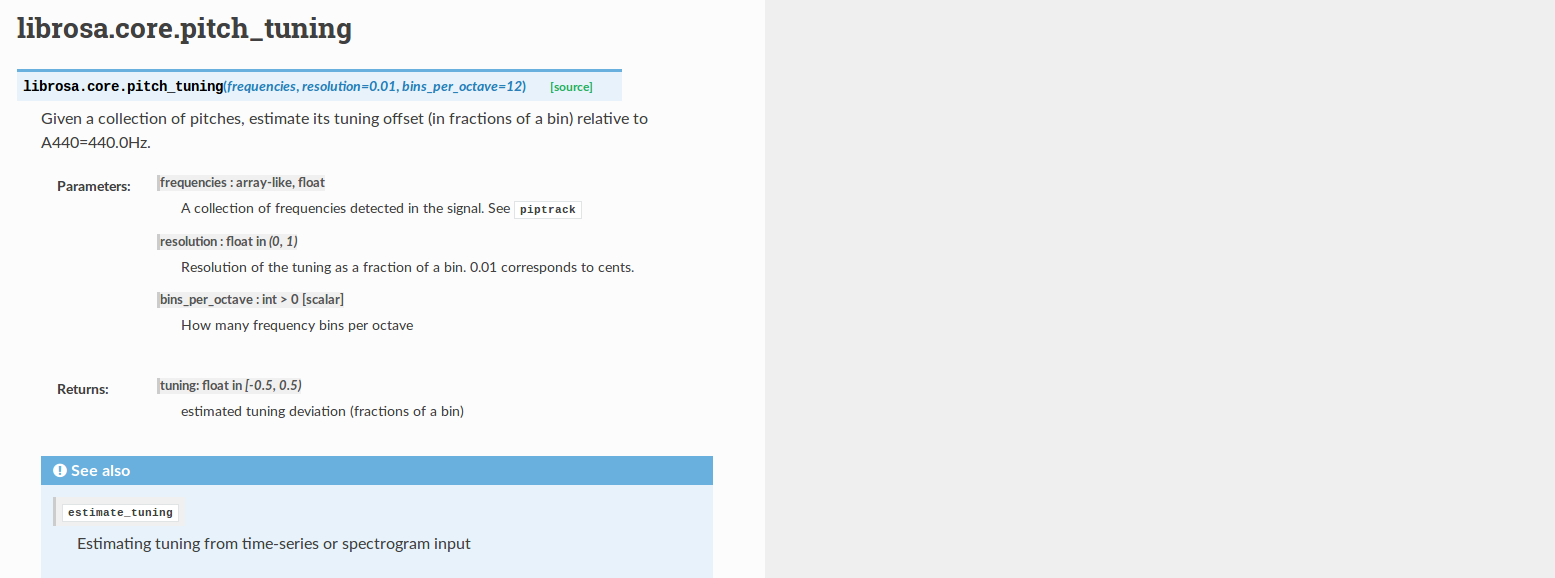

In [8]:
def pitch_tuning(y, sr):
    pitches, magnitudes = librosa.piptrack(y, sr)
    return {'pitch_tuning' : librosa.pitch_tuning(pitches)}

pitch_tuning(y, sr)

{'pitch_tuning': 0.030000000000000027}

### frequency spectrum

In [9]:
def get_spectral_properties(y: np.ndarray, fs: int) -> dict:
    spec = np.abs(np.fft.rfft(y))
    freq = np.fft.rfftfreq(len(y), d=1 / fs)
    spec = np.abs(spec)
    amp = spec / spec.sum()
    mean = (freq * amp).sum()
    sd = np.sqrt(np.sum(amp * ((freq - mean) ** 2)))
    amp_cumsum = np.cumsum(amp)
    median = freq[len(amp_cumsum[amp_cumsum <= 0.5]) + 1]
    mode = freq[amp.argmax()]
    Q25 = freq[len(amp_cumsum[amp_cumsum <= 0.25]) + 1]
    Q75 = freq[len(amp_cumsum[amp_cumsum <= 0.75]) + 1]
    IQR = Q75 - Q25
    z = amp - amp.mean()
    w = amp.std()
    skew = ((z ** 3).sum() / (len(spec) - 1)) / w ** 3
    kurt = ((z ** 4).sum() / (len(spec) - 1)) / w ** 4

    result_d = {
        'freq_mean': mean,
        'freq_sd': sd,
        'freq_median': median,
        'freq_mode': mode,
        'freq_Q25': Q25,
        'freq_Q75': Q75,
        'freq_IQR': IQR,
        'freq_skew': skew,
        'freq_kurt': kurt
    }

    return result_d


get_spectral_properties(y, sr)


{'freq_mean': 3178.345638247113,
 'freq_sd': 3067.2601892657194,
 'freq_median': 2073.8235294117644,
 'freq_mode': 218.23529411764702,
 'freq_Q25': 510.8823529411764,
 'freq_Q75': 5116.372549019607,
 'freq_IQR': 4605.49019607843,
 'freq_skew': 11.992729571886784,
 'freq_kurt': 235.2230294659141}

### onset intensity

In [10]:
def get_onset_intensity(y, sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median, fmax=8000, n_mels=256)
    onset_int = np.mean(list(onset_env))
    return {'onset_int' : onset_int}

get_onset_intensity(y, sr)

{'onset_int': 0.26982749}

### pipeline

In [11]:
root    = 'Tracks for Milan'
quality = os.listdir(root)
tracks  = []

for q in quality:
    
    files = os.listdir('Tracks for Milan/' + q)
    
    for fn in files:
        
        track = {}
        track['filename'] = fn
        track['quality']  = q
      
    
        y, sr = librosa.load('Tracks for Milan/' + q + '/' + fn, duration = 4.2)
    
        track.update(get_length(y, sr))
        track.update(get_loudness(filename))
        track.update(get_temp(y, sr))
        track.update(pitch_tuning(y, sr))
        track.update(get_spectral_properties(y, sr))
        track.update(get_onset_intensity(y, sr))
        tracks.append(track)
tracks                     

[{'filename': 'Da Hool feat. Julia DeTomaso - Dancing In The Rain.wav',
  'quality': 'Bad',
  'length': 4.2,
  'loudness': -7.567026825050204,
  'tempo': 83.35433467741936,
  'pitch_tuning': 0.07999999999999996,
  'freq_mean': 2173.0187454805746,
  'freq_sd': 1503.0265795436183,
  'freq_median': 2122.3809523809523,
  'freq_mode': 262.1428571428571,
  'freq_Q25': 996.4285714285713,
  'freq_Q75': 3163.333333333333,
  'freq_IQR': 2166.9047619047615,
  'freq_skew': 7.246310785249223,
  'freq_kurt': 102.89512813490127,
  'onset_int': 0.93775326},
 {'filename': 'Malifoo feat. Shach Seven - No Love.wav',
  'quality': 'Bad',
  'length': 4.2,
  'loudness': -7.567026825050204,
  'tempo': 123.046875,
  'pitch_tuning': 0.030000000000000027,
  'freq_mean': 2889.443672271026,
  'freq_sd': 3086.419191253231,
  'freq_median': 1462.142857142857,
  'freq_mode': 60.238095238095234,
  'freq_Q25': 371.66666666666663,
  'freq_Q75': 5087.857142857142,
  'freq_IQR': 4716.190476190475,
  'freq_skew': 11.269203

In [13]:
df = pd.DataFrame(tracks)
df.index = df.filename
df = df.drop(columns = ['filename'])
df.head()

,quality,length,loudness,tempo,pitch_tuning,freq_mean,freq_sd,freq_median,freq_mode,freq_Q25,freq_Q75,freq_IQR,freq_skew,freq_kurt,onset_int
filename,,,,,,,,,,,,,,,
Da Hool feat. Julia DeTomaso - Dancing In The Rain.wav,Bad,4.2,-7.567027,83.354335,0.08,2173.018745,1503.026580,2122.380952,262.142857,996.428571,3163.333333,2166.904762,7.246311,102.895128,0.937753
Malifoo feat. Shach Seven - No Love.wav,Bad,4.2,-7.567027,123.046875,0.03,2889.443672,3086.419191,1462.142857,60.238095,371.666667,5087.857143,4716.190476,11.269203,194.436059,0.803765
Dr. Shiver ft. Zeek Burse - We Need Hope.wav,Bad,4.2,-7.567027,123.046875,-0.01,2222.900376,2031.038601,1879.285714,523.333333,652.142857,2847.857143,2195.714286,10.212185,185.782676,0.751645
Teddy Beats x Camden Levine feat. Jolee Nikoal - Waiting For Tonight.wav,Bad,4.2,-7.567027,107.666016,-0.01,2356.903106,2586.179516,1211.666667,207.619048,524.523810,3323.571429,2799.047619,9.605380,153.107295,1.485797
Thomas Gold - Gold (feat. sonofsteve).wav,Bad,4.2,-7.567027,151.999081,0.04,2568.096932,2811.185045,1312.857143,261.904762,300.238095,4214.523810,3914.285714,12.110949,216.065005,0.804664


In [25]:
df.to_csv('musical_features_demo.csv')

In [26]:
len(df.keys())

15